In [1]:
import itertools as itt
import pathlib as pl
from collections import defaultdict
from configparser import ConfigParser
from math import factorial

import joblib as jl
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as sst
from IPython.display import Image
from plotly.subplots import make_subplots

from src.data.load import load
from src.root_path import config_path, root_path
from src.visualization.interactive import plot_raw_pair, plot_pupil_so_effects
from src.visualization.palette import *
from src.utils.tools import decimate_xy

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

folder = root_path / 'reports' / 'figures' / 'paper'
folder.mkdir(parents=True, exist_ok=True)

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-12-05 120448.log


In [2]:
def plot_pupil_effect(cellid, contexts, probe):

    big = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR, pupil='big')['data']
    small = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR, pupil='small')['data']

    fig = make_subplots(rows=2, cols=2, shared_yaxes='rows', shared_xaxes=False,
                        subplot_titles=['big', 'small', 'raw pupil trace'],

                        specs=[[{}, {}],
                               [{'colspan':2},None]]

                        )

    # add psth traces to the suboplots
    _ = fig.add_traces(big, rows=[1]*len(big), cols=[1]*len(big))
    _ = fig.update_traces(showlegend=False)

    _ = fig.add_traces(small, rows=[1]*len(small), cols=[2]*len(small))

    # vertical lines of probe onset
    for cc in range(2):
        _ = fig.add_vline(x=0, line=dict(color='black',
                                     dash='dot'),
                      row=1, col=cc+1)

    # raw pupil trace
    recs, _ = load(cellid.split('-')[0], rasterfs=20, recache=False, pupil=True)
    pupil_trace = recs['perm0']['pupil']._data.squeeze(axis=0)
    t = np.linspace(0,pupil_trace.size/20, pupil_trace.size, endpoint=False)

    _ = fig.add_trace(go.Scatter(x=t, y=pupil_trace, mode='lines',
                                 line=dict(color='black'),
                                 showlegend=False),
                  row=2, col=1)

    _ = fig.add_hline(y=np.median(pupil_trace),
                      line=dict(color='gray',
                                dash='dot'),
                      row=2, col=1)

    fig.update_layout(margin=dict(l=10, r=10, t=50, b=10),)

    return fig

def rotate(arr, angle):
    '''rotate a nx2 array in the direction of the angle, in degrees, clockwise'''
    angle = np.deg2rad(angle)
    rot_mat = np.asarray(
        [[np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]]
    )
    return arr @ rot_mat

def rotate_regression(reg, angle):
    '''rotate a sst.linregress output  in the direction of the angle, in degrees, clockwise'''
    angle = np.deg2rad(-angle)
    slope = (reg.slope * np.cos(angle) + np.sin(angle)) / \
             (np.cos(angle) - reg.slope * np.sin(angle))

    intecept = reg.intercept / (np.cos(angle) - reg.slope * np.sin(angle))

    return  slope, intecept

# new plan
1. find neurons with significant pupil first order effects, i.e. effects on firing rate (not on deltas or context stuff)
2. There is no need to do split the probe response by time, use full length
3. There is no need to keep track of contex information, aggregate by neuron and probe
4. plot the histograms for modulation coefficient for each site
5. the histogram can potentially aggregate by each neuron mean

## First order first

In [3]:
# New firing rates, the file is a misnomer, it has not deltas
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220808_pupil_fr_by_instance'
first_ord_DF = jl.load(fr_DF_file
                ).query("part == 'probe' and chunk == 'full'"
                        # " and pupil != 'full'"
                        ).drop(columns=['chunk', 'part', 'metric']
                               ).reset_index(drop=True)

first_ord_DF = first_ord_DF.groupby(['id', 'site', 'probe', 'pupil'],
                                    observed=True, dropna=True).agg(value=('value',np.nanmean)).reset_index()

print(first_ord_DF.shape)
first_ord_DF.head()

(35316, 5)


,id,site,probe,pupil,value
0,CRD003b-02-2,CRD003b,1,small,0.011436
1,CRD003b-02-2,CRD003b,1,big,0.081555
2,CRD003b-02-2,CRD003b,1,full,0.048833
3,CRD003b-02-2,CRD003b,2,small,0.204172
4,CRD003b-02-2,CRD003b,2,big,0.242648


In [4]:
pivoted_fo = first_ord_DF.pivot_table(index=['id','site','probe',],
                                   columns='pupil', values='value',
                                   dropna=True, observed=True).reset_index().copy()
pivoted_fo['mod_coeff'] = (pivoted_fo['big'] - pivoted_fo['small']) /  (pivoted_fo['big'] + pivoted_fo['small'])
pivoted_fo['mod_coeff_corrected'] = (pivoted_fo['big'] - pivoted_fo['small']) /\
                                    (np.abs(pivoted_fo['big']) + np.abs(pivoted_fo['small']))

pivoted_fo['abs_mod_coeff'] = np.abs(pivoted_fo['mod_coeff'])
pivoted_fo['abs_mod_coeff_corrected'] = np.abs(pivoted_fo['mod_coeff_corrected'])

pivoted_fo.head()

pupil,id,site,probe,big,full,small,mod_coeff,mod_coeff_corrected,abs_mod_coeff,abs_mod_coeff_corrected
0,CRD003b-02-2,CRD003b,1,0.081555,0.048833,0.011436,0.754032,0.754032,0.754032,0.754032
1,CRD003b-02-2,CRD003b,2,0.242648,0.224692,0.204172,0.086109,0.086109,0.086109,0.086109
2,CRD003b-02-2,CRD003b,3,0.058901,0.056888,0.054586,0.038022,0.038022,0.038022,0.038022
3,CRD003b-02-2,CRD003b,4,-0.104708,-0.102863,-0.100753,0.019251,-0.019251,0.019251,0.019251
4,CRD003b-03-1,CRD003b,1,-0.024245,-0.063753,-0.108905,-0.635821,0.635821,0.635821,0.635821


In [5]:

panels = defaultdict(list)

In [6]:
# parse for weird
def calculate_hacky_linreg(df, x, y):
    x = df[x]
    y = df[y]
    full = np.stack([x,y], axis=1)

    # cheap trick to have the regression tend to the diagonal
    rotdat = rotate(full,45)
    reg = sst.linregress(rotdat[:,0], rotdat[:,1])
    slope, intecept = rotate_regression(reg, -45)

    print(f'hacky linregress: slope={slope:.4f}, intercept={intecept:.4f}, rvalue={reg.rvalue:.4f}, pvalue={reg.pvalue:.4f}')

    return reg, slope, intecept


def plot_dev_fom_id(df,x,y, decimate=1000, by_quantiles=True):

    xname = x
    yname = y

    x = df[x].values
    y = df[y].values
    full = np.stack([x,y], axis=1)
    print(f'n={len(x)} points')

    # cheap trick to have the regression tend to the diagonal
    rotdat = rotate(full,45)
    reg = sst.linregress(rotdat[:,0], rotdat[:,1])

    slope, intecept = rotate_regression(reg, -45)
    print(f'hacky linregress: slope0={reg.slope}, slope={slope:.4f}, '
          f'intercept0={reg.intercept}, intercept={intecept:.4f}, '
          f'rvalue={reg.rvalue:.4f}, pvalue={reg.pvalue:.4f}')

    print(sst.wilcoxon(x, y))


    # main scatter
    fig = go.Figure()
    if decimate == 0:
        xm, ym = x, y
    else:
        xm, ym = decimate_xy(x, y, decimate, by_quantiles)
    _ = fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(size=1,
                                             opacity=0.3,
                                             color='black'),
                                 showlegend=False))

    # interval for unit and regression
    interval = np.asarray([np.min([xm.min(),ym.min()]),
                           np.max([xm.max(),ym.max()])])

    # regression
    _ = fig.add_trace(go.Scatter(x=interval, y=interval*slope+intecept, mode='lines',
                             line=dict(dash='solid',
                                       width=1,
                                       color='black'),
                             showlegend=False))

    # unit line

    _ = fig.add_trace(go.Scatter(x=interval, y=interval, mode='lines',
                             line=dict(color='lightgray', dash='dot', width=1),
                             showlegend=False))

    # mean marker
    print(f'mean x:{x.mean()}, mean y: {y.mean()}')
    _ = fig.add_trace(go.Scatter(x=[x.mean()], y=[y.mean()], mode='markers',
                             marker=dict(color='green',
                                         size=4,
                                         symbol='cross'),
                             showlegend=False))

    _ = fig.update_layout(template='simple_white',
                      margin=dict(l=10, r=10, t=10, b=10),
                      xaxis=dict(autorange=True,
                                 constrain='domain',
                                 title_text=xname),
                      yaxis=dict(scaleanchor='x',
                                 constrain='domain',
                                 title_text=yname)
                      )

    return fig

n=2379 points
hacky linregress: slope0=-0.049157114583250956, slope=0.9063, intercept0=-0.010895003515153438, intercept=-0.0147, rvalue=-0.1602, pvalue=0.0000
WilcoxonResult(statistic=811879.5, pvalue=3.143498184072872e-71)
mean x:0.4225231111049652, mean y: 0.3682434558868408


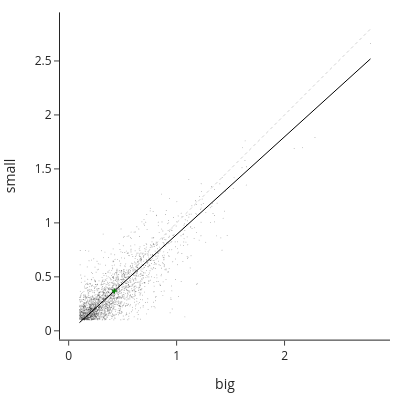

In [7]:
panelname = "first_order_scatter"
toplot = pivoted_fo.query(f"(big > 0.1 and small > 0.1)").copy()
fig = plot_dev_fom_id(toplot, x='big', y='small', decimate=0, by_quantiles=True)

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

img_bytes = fig.to_image(format="png", width=400, height=400)
Image(img_bytes)

# Second order effects

having found a handful of neurons that are worth looking at, now try to determine the effect of these big pupil
changes in the contextual modulation.
1. get second order data i.e. delta FR as a funcion of pupil size
2. taking care of flippign delta FR so all are possitive for the pupil independent fr
3. properly casting the data types to save e on memory
4. filter by signiricant instancese
5. order by first order effects
6. plotting only the best examples

In [8]:
fr_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220808_pupil_fr_by_instance'
second_ord_DF = jl.load(fr_DF_file
                ).query("part == 'probe'"
                        ).reset_index(drop=True)

print(second_ord_DF.shape)
second_ord_DF.head()


# Calculate delta firing rate for pairs of contexts
second_ord_DF = second_ord_DF.pivot_table(index=['id', 'site', 'chunk', 'probe', 'pupil'], columns=['context'],
                                   values='value', aggfunc='first', dropna=True, observed=True)

n_comb = int(factorial(second_ord_DF.shape[1]) /
             (2 * factorial(second_ord_DF.shape[1] - 2)))
ctx_pair_R = np.full((second_ord_DF.shape[0], n_comb), np.nan)
new_cols = list()
for pr_idx, (c0, c1) in enumerate(itt.combinations(second_ord_DF.columns, r=2)):
    new_cols.append(f'{c0:02}_{c1:02}')
    ctx_pair_R[:, pr_idx] = second_ord_DF.values[:, c0] - second_ord_DF.values[:, c1]

# Melts back into long format and ensures column typing for memory efficiency
second_ord_DF = pd.DataFrame(index=second_ord_DF.index, columns=new_cols, data=ctx_pair_R
                      ).melt(var_name='context_pair', value_name='delta_fr', ignore_index=False).dropna().reset_index()
second_ord_DF['context_pair'] = second_ord_DF['context_pair'].astype('category')
second_ord_DF.head()

(1646550, 9)


,id,site,chunk,probe,pupil,context_pair,delta_fr
0,CRD003b-02-2,CRD003b,A,1,small,00_01,-0.057533
1,CRD003b-02-2,CRD003b,A,1,big,00_01,-0.050341
2,CRD003b-02-2,CRD003b,A,1,full,00_01,-0.053698
3,CRD003b-02-2,CRD003b,A,2,small,00_01,0.000000
4,CRD003b-02-2,CRD003b,A,2,big,00_01,0.100683


In [9]:
pivoted_so = second_ord_DF.pivot_table(index=['id', 'site', 'context_pair', 'probe', 'chunk'],
                                   columns='pupil', values='delta_fr', aggfunc='first',
                                   dropna=True, observed=True).reset_index()

# flips firing rates
flipper = (pivoted_so.full.values > 0) * 2 - 1
pivoted_so['small_flipped'] = pivoted_so['small'] * flipper
pivoted_so['big_flipped'] = pivoted_so['big'] * flipper
pivoted_so['full_flipped'] = pivoted_so['full'] * flipper
del(flipper)

pivoted_so['mod_coeff'] = (pivoted_so['big_flipped'] - pivoted_so['small_flipped']) /\
                          (pivoted_so['big_flipped'] + pivoted_so['small_flipped'])

pivoted_so['mod_coeff_corrected'] = (pivoted_so['big_flipped'] - pivoted_so['small_flipped']) /\
                          (np.abs(pivoted_so['big_flipped']) + np.abs(pivoted_so['small_flipped']))


pivoted_so['abs_mod_coeff'] = np.abs(pivoted_so['mod_coeff'])
pivoted_so['abs_mod_coeff_corrected'] = np.abs(pivoted_so['mod_coeff_corrected'])

# some instances of zero FR and no difference between pupils leads to nan and inf mod_coeff, removes those rows
pivoted_so.replace([-np.inf, np.inf], np.nan, inplace=True)
pivoted_so.dropna(axis='index', inplace=True)

print(pivoted_so.shape)
pivoted_so.head()

(2366273, 15)


pupil,id,site,context_pair,probe,chunk,big,full,small,small_flipped,big_flipped,full_flipped,mod_coeff,mod_coeff_corrected,abs_mod_coeff,abs_mod_coeff_corrected
0,CRD003b-02-2,CRD003b,00_01,1,A,-0.050341,-0.053698,-0.057533,0.057533,0.050341,0.053698,-0.066667,-0.066667,0.066667,0.066667
1,CRD003b-02-2,CRD003b,00_01,1,B,0.100683,0.107395,0.115066,0.115066,0.100683,0.107395,-0.066667,-0.066667,0.066667,0.066667
2,CRD003b-02-2,CRD003b,00_01,1,C,0.805463,0.402732,-0.057533,-0.057533,0.805463,0.402732,1.153846,1.000000,1.153846,1.000000
3,CRD003b-02-2,CRD003b,00_01,1,D,0.251707,0.053698,-0.172599,-0.172599,0.251707,0.053698,5.363637,1.000000,5.363637,1.000000
4,CRD003b-02-2,CRD003b,00_01,1,full,0.276878,0.127532,-0.043150,-0.043150,0.276878,0.127532,1.369231,1.000000,1.369231,1.000000


### filter for contextual significance

In [10]:
 # Cluster Mass significant contextual effects
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220719_chunked_amplitude_DF'

metrics = ['integral', 'integral_A', 'integral_B', 'integral_C', 'integral_D',]
DF = jl.load(summary_DF_file).query(f"source == 'real' and metric in {metrics} and "
                                    f"cluster_threshold == 0.05 and mult_comp_corr == 'bf_cp' and "
                                    f"analysis == 'SC' and "
                                    f"diff_metric == 'delta_FR' and "
                                    f"value > 0")

DF['chunk'] = DF['metric'].str.split('_').str[-1]
DF.loc[:,'chunk'].replace({'integral': 'full'}, inplace=True)

DF.drop(columns=['source', 'cluster_threshold', 'mult_comp_corr', 'diff_metric',
                 'analysis', 'metric', 'stim_count',], inplace=True)
DF.reset_index(drop=True, inplace=True)

for col in ['id','context_pair','probe','site', 'region', 'chunk']:
    DF[col] = DF[col].astype('category')

DF['value'] = pd.to_numeric(DF.value, downcast='float')
DF.head()

,id,context_pair,probe,value,site,region,chunk
0,TNC008a-01-1,00_01,1,209.010117,TNC008a,A1,full
1,TNC008a-05-1,00_01,1,97.002335,TNC008a,A1,full
2,TNC008a-06-2,00_01,1,399.907379,TNC008a,A1,full
3,TNC008a-15-1,00_01,1,133.188477,TNC008a,A1,full
4,TNC008a-23-1,00_01,1,105.714561,TNC008a,A1,full


#### merge tables of first, second order and signif contextual effects

In [11]:
full_merge = pd.merge(pivoted_fo, pivoted_so, on=['id', 'site', 'probe'], suffixes=('_fo', '_so'), validate='1:m')

full_merge = pd.merge(full_merge, DF, on=['id','site','context_pair', 'probe', 'chunk',], validate='m:1')
full_merge.rename(columns={'value': 'T-score_integral'}, inplace=True)
print(full_merge.shape)
full_merge.head()

(106312, 24)


,id,site,probe,big_fo,full_fo,small_fo,mod_coeff_fo,mod_coeff_corrected_fo,abs_mod_coeff_fo,abs_mod_coeff_corrected_fo,...,small_so,small_flipped,big_flipped,full_flipped,mod_coeff_so,mod_coeff_corrected_so,abs_mod_coeff_so,abs_mod_coeff_corrected_so,T-score_integral,region
0,CRD003b-03-1,CRD003b,4,0.394620,0.376417,0.355615,0.051991,0.051991,0.051991,0.051991,...,-0.496433,0.496433,0.868757,0.695006,0.272727,0.272727,0.272727,0.272727,190.299225,A1
1,CRD003b-03-1,CRD003b,4,0.394620,0.376417,0.355615,0.051991,0.051991,0.051991,0.051991,...,-1.063784,1.063784,1.054920,1.059057,-0.004184,-0.004184,0.004184,0.004184,165.477585,A1
2,CRD003b-03-1,CRD003b,4,0.394620,0.376417,0.355615,0.051991,0.051991,0.051991,0.051991,...,-0.833298,0.833298,0.899784,0.868757,0.038363,0.038363,0.038363,0.038363,355.776825,A1
3,CRD003b-05-1,CRD003b,2,-0.059405,-0.049900,-0.039038,0.206898,-0.206898,0.206898,0.206898,...,0.257275,0.257275,0.375193,0.320165,0.186441,0.186441,0.186441,0.186441,95.048851,A1
4,CRD003b-05-1,CRD003b,2,-0.059405,-0.049900,-0.039038,0.206898,-0.206898,0.206898,0.206898,...,-0.085758,-0.085758,0.206356,0.070036,2.422222,1.000000,2.422222,1.000000,95.048851,A1


### First and second order effects
There is no clear relationship between them, even with the possible flip of sign
of Second order effects, I woudl expect a C shaped graph

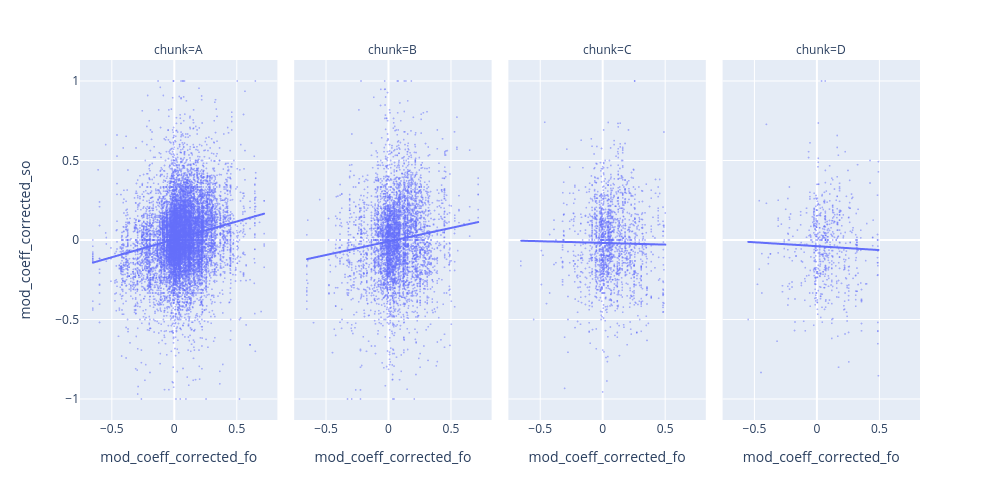

In [12]:
# relate first order  to second order pupil effects

toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1 "
                          f"and ((full_so <= -0.3) or (0.3 <= full_so)) "
                          f"and chunk != 'full'"
                          )

fig = px.scatter(toplot, x='mod_coeff_corrected_fo', y='mod_coeff_corrected_so', facet_col='chunk',
                 trendline='ols',
                 category_orders={'chunk': ['A', 'B', 'C', 'D']})
fig.update_traces(marker=dict(size=2, opacity=0.5))
fig.update_xaxes()

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

In [13]:
# the p values from the regression support the idea that this effect is only significant on chunks A and B.
for chnk in ['A','B','C','D']:
    toreg = toplot.query(f"chunk == '{chnk}'")
    x = toreg.mod_coeff_corrected_fo
    y = toreg.mod_coeff_corrected_so
    print(f'\n{chnk}: {sst.linregress(x,y)}')


A: LinregressResult(slope=0.22426272924409751, intercept=0.003589782740599533, rvalue=0.17899751756713206, pvalue=4.1091512841505865e-93, stderr=0.010867183540217668, intercept_stderr=0.0019228237715060764)

B: LinregressResult(slope=0.16970742290924853, intercept=-0.009773474662560473, rvalue=0.112595230716621, pvalue=2.044343427349602e-15, stderr=0.02130820395840186, intercept_stderr=0.003796646054057842)

C: LinregressResult(slope=-0.021192776402583945, intercept=-0.01824679971547236, rvalue=-0.014157556919922105, pvalue=0.5466640450091653, stderr=0.03515257221311604, intercept_stderr=0.006100924977403384)

D: LinregressResult(slope=-0.04896830522872598, intercept=-0.03874396064988124, rvalue=-0.03443526489697582, pvalue=0.37421805202555336, stderr=0.05507022964381913, intercept_stderr=0.010403276863080554)


n=729
mean MI: first_ord=0.05723521113395691, second_ord-0.002252992559307253
mod_coeff_corrected_fo: Ttest_1sampResult(statistic=32.51701086136899, pvalue=1.985764191529038e-219)
mod_coeff_corrected_so: Ttest_1sampResult(statistic=-0.9298304766438223, pvalue=0.35248373891118323)
first vs second order modulation index:
LinregressResult(slope=0.20112585352708118, intercept=-0.01376447849519237, rvalue=0.146104908993019, pvalue=3.050376360954367e-44, stderr=0.01433725882461161, intercept_stderr=0.0025337102428682062)


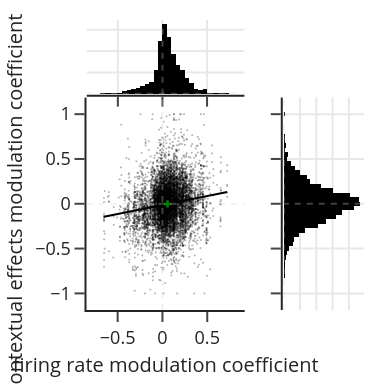

In [14]:
panelname = "first_vs_second_order"
toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          f" and chunk == 'full'"
                          ).copy()
print(f'n={toplot.id.nunique()}')


xstr = 'mod_coeff_corrected_fo'
ystr = 'mod_coeff_corrected_so'

print(f'mean MI: first_ord={toplot[xstr].mean()}, second_ord{toplot[ystr].mean()}')

# main scatter
fig = px.scatter(data_frame=toplot,
                 x=xstr, y=ystr,
                 hover_name='id', hover_data=['probe'],
                 trendline='ols',
                 render_mode='svg',
                 marginal_x='histogram',
                 marginal_y='histogram',
                 )

fig.update_traces(marker=dict(color='black',
                              size=1, opacity=0.3),
                  line=dict(color='black',
                            width=1,
                            dash='solid'),
                  selector=dict(type='scatter')
                  )

fig.update_traces(nbinsx=50, nbinsy=50,
                  marker=dict(line_width=0,
                              color='black',
                              opacity=1),
                  opacity=1,
                  selector=dict(type='histogram'),
                  )

# mean marker
fig.add_trace(go.Scatter(x=[toplot[xstr].mean()],
                         y=[toplot[ystr].mean()],
                         mode='markers',
                         marker=dict(color='green',
                                     size=3,
                                     symbol='cross'),
                         showlegend=False))

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend([trace for trace in fig['data'] if trace.type != 'histogram'])

fig.add_vline(x=0, line=dict(color='lightgray', dash='dot', width=1))
fig.add_hline(y=0, line=dict(color='lightgray', dash='dot', width=1))

####### statistical tests #######
# marginal differece from zero
for marg in [xstr, ystr]:
    out = sst.ttest_1samp(toplot[marg],0)
    print(f'{marg}: {out}')

# correaltion
print(f"first vs second order modulation index:"
      f"\n{sst.linregress(toplot[xstr], toplot[ystr])}")


####### Formating #######
w, h = 2, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10))

fig.update_xaxes(title=dict(text='firing rate modulation coefficient',
                            font_size=10, standoff=0),
                 tickfont_size=9,
                 scaleanchor='y', constrain='domain', col=1, row=1)
fig.update_yaxes(title=dict(text='contextual effects modulation coefficient',
                            font_size=10, standoff=0),
                 tickfont_size=9, constrain='domain',
                 col=1, row=1)

filename = folder / 'fig6_first_vs_second_ord_scatter'

fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)



###########
chunk A, n_neuron=776, n_instanceses=12868
mean MI: first_ord=0.05744515731930733, second_ord0.016472590502883938
FR_MI: Ttest_1sampResult(statistic=38.93645540074866, pvalue=0.0)
ctx_MI: Ttest_1sampResult(statistic=8.911581505310462, pvalue=5.701397036504273e-19)
first vs second order modulation index:
LinregressResult(slope=0.22426272924409751, intercept=0.003589782740599533, rvalue=0.17899751756713206, pvalue=4.1091512841505865e-93, stderr=0.010867183540217668, intercept_stderr=0.0019228237715060764)
2000

###########
chunk B, n_neuron=513, n_instanceses=4942
mean MI: first_ord=0.06500754505395889, second_ord0.0012587882782037574
FR_MI: Ttest_1sampResult(statistic=27.54461568884392, pvalue=1.6922510034290816e-155)
ctx_MI: Ttest_1sampResult(statistic=0.3538708609342707, pvalue=0.7234507643474588)
first vs second order modulation index:
LinregressResult(slope=0.16970742290924853, intercept=-0.009773474662560473, rvalue=0.112595230716621, pvalue=2.044343427349602e-15, stde

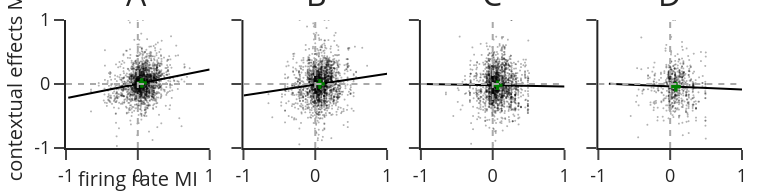

In [15]:
# statistical tests for the regression across all time chunks
chunks = ['A', 'B', 'C', 'D']
fig = make_subplots(1, 4, shared_xaxes=True, shared_yaxes=True,
                    subplot_titles=chunks)

for coln, chunk in enumerate(chunks):
    panelname = f"first_vs_second_order_{chunk}"

    toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                              f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                              f" and chunk == '{chunk}'"
                              ).copy()

    x = toplot['mod_coeff_corrected_fo'].values
    y = toplot['mod_coeff_corrected_so'].values

    ####### statistical tests #######
    print(f'\n###########\nchunk {chunk}, n_neuron={toplot.id.nunique()}, n_instanceses={len(x)}')
    print(f'mean MI: first_ord={x.mean()}, second_ord{y.mean()}')
    # marginal differece from zero
    for marg, vctr in zip(['FR_MI', 'ctx_MI'], [x, y]):
        out = sst.ttest_1samp(vctr, 0)
        print(f'{marg}: {out}')

    # correaltion
    print(f"first vs second order modulation index:"
          f"\n{sst.linregress(x, y)}")

    # main scatter
    xm, ym = decimate_xy(x, y, 2000, by_quantiles=False, rng=np.random.default_rng(42))
    print(len(xm))
    _ = fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers',
                                 marker=dict(size=1,
                                             opacity=0.3,
                                             color='black'),
                                 showlegend=False),
                      row=1, col=coln + 1)

    # interval for unit and regression
    interval = np.asarray([np.min([xm.min(), ym.min()]),
                           np.max([xm.max(), ym.max()])])

    # regression
    reg = sst.linregress(x, y)
    _ = fig.add_trace(go.Scatter(x=interval, y=interval * reg.slope + reg.intercept, mode='lines',
                                 line=dict(dash='solid',
                                           width=1,
                                           color='black'),
                                 showlegend=False),
                      row=1, col=coln + 1)

    # mean marker
    _ = fig.add_trace(go.Scatter(x=[x.mean()],
                                 y=[y.mean()],
                                 mode='markers',
                                 marker=dict(color='green',
                                             size=4,
                                             symbol='cross'),
                                 showlegend=False),
                      row=1, col=coln + 1)

    if panelname in panels.keys():
        panels.pop(panelname)

    panels[panelname].extend([trace for trace in fig['data'] if trace.type != 'histogram'])

    fig.add_vline(x=0, line=dict(color='darkgray', dash='dot', width=1), opacity=1, row=1, col=coln + 1)
    fig.add_hline(y=0, line=dict(color='darkgray', dash='dot', width=1), opacity=1, row=1, col=coln + 1)

####### Formating #######
w, h = 4, 1
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10))

fig.update_xaxes(tickfont_size=9,
                 range=[-1, 1],
                 tickmode='array',
                 tickvals=[-1, 0, 1],
                 ticktext=[-1, 0, 1],
                 )
fig.update_yaxes(tickfont_size=9,
                 range=[-1, 1],
                 tickmode='array',
                 tickvals=[-1, 0, 1],
                 ticktext=[-1, 0, 1],
                 )

fig.update_xaxes(title=dict(text='firing rate MI',
                            font_size=10, standoff=0),
                 col=1, row=1
                 )
fig.update_yaxes(title=dict(text='contextual effects MI',
                            font_size=10, standoff=0),
                 col=1, row=1,
                 )

filename = folder / 'fig6_first_vs_second_ord_scatter_chunks'

fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

# first and second order scatters


######## first order effects ########
n=1144 neurons
n=2379 points
hacky linregress: slope0=-0.049157114583250956, slope=0.9063, intercept0=-0.010895003515153438, intercept=-0.0147, rvalue=-0.1602, pvalue=0.0000
WilcoxonResult(statistic=811879.5, pvalue=3.143498184072872e-71)
mean x:0.4225231111049652, mean y: 0.3682434558868408

######## second order effects ########
n=776 neurons
n=12868 points
hacky linregress: slope0=-0.012977748305493014, slope=0.9744, intercept0=-0.004394408130441101, intercept=-0.0061, rvalue=-0.0408, pvalue=0.0000
WilcoxonResult(statistic=35487693.5, pvalue=1.0449327040765732e-21)
mean x:0.9929002753389726, mean y: 0.9613242102558194


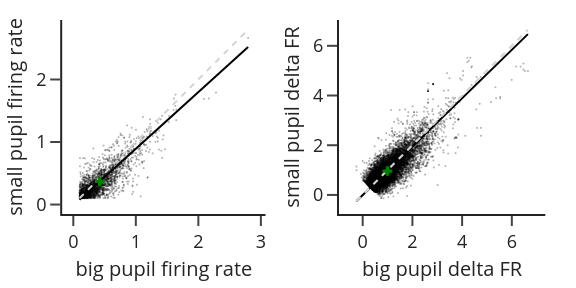

In [16]:
fig = make_subplots(1, 2)

# first order effects
toplot = pivoted_fo.query(f"(big > 0.1 and small > 0.1)").copy()
print("\n######## first order effects ########")
print(f'n={len(toplot.id.unique())} neurons')
f = plot_dev_fom_id(toplot, x='big', y='small', decimate=0, by_quantiles=False)['data']
fig.add_traces(f, cols=[1] * len(f), rows=[1] * len(f))

# second order effects
toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          f" and chunk == 'A'"
                          ).copy()

print("\n######## second order effects ########")
print(f'n={len(toplot.id.unique())} neurons')
f = plot_dev_fom_id(toplot, x='big_flipped', y='small_flipped', decimate=0, by_quantiles=False)['data']
fig.add_traces(f, cols=[2] * len(f), rows=[1] * len(f))

# formating
w, h = 3, 1.5
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),

                  xaxis=dict(scaleanchor='y',
                             title_text='big pupil firing rate'),
                  yaxis_title_text='small pupil firing rate',

                  xaxis2=dict(scaleanchor='y2',
                              title_text='big pupil delta FR'),
                  yaxis2_title_text='small pupil delta FR',
                  )

fig.update_xaxes(title=dict(font_size=10, standoff=0),
                 tickfont_size=9,
                 constrain='domain')
fig.update_yaxes(title=dict(font_size=10, standoff=0),
                 tickfont_size=9,
                 constrain='domain')


filename = folder / 'fig6_big_vs_small_regressions'

fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))


img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)


######## second order effects ########
chunk A
n=776 neurons
n=12868 points
hacky linregress: slope0=-0.012977748305493014, slope=0.9744, intercept0=-0.004394408130441101, intercept=-0.0061, rvalue=-0.0408, pvalue=0.0000
WilcoxonResult(statistic=35487693.5, pvalue=1.0449327040765732e-21)
mean x:0.9929002753389726, mean y: 0.9613242102558194

######## second order effects ########
chunk B
n=513 neurons
n=4942 points
hacky linregress: slope0=-0.04261912011322763, slope=0.9182, intercept0=0.04315697410586272, intercept=0.0585, rvalue=-0.0889, pvalue=0.0000
WilcoxonResult(statistic=5799732.5, pvalue=0.442448162487579)
mean x:0.8637414088661929, mean y: 0.8516654557514919

######## second order effects ########
chunk C
n=298 neurons
n=1815 points
hacky linregress: slope0=0.0710641397431568, slope=1.1530, intercept0=-0.053985701818751404, intercept=-0.0822, rvalue=0.1471, pvalue=0.0000
WilcoxonResult(statistic=684738.0, pvalue=8.55657989368724e-06)
mean x:0.8506798604795756, mean y: 0.89864

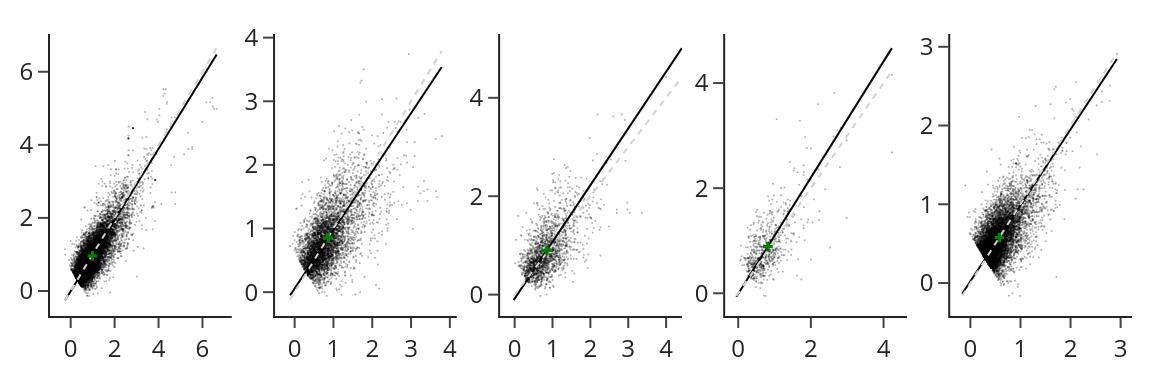

In [17]:
# second order effects
fig = make_subplots(1,5)
for cc, chunk in enumerate(['A', 'B', 'C', 'D', 'full']):
    toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                              f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                              f" and chunk == '{chunk}'"
                              ).copy()

    print("\n######## second order effects ########")
    print(f'chunk {chunk}')
    print(f'n={len(toplot.id.unique())} neurons')
    f = plot_dev_fom_id(toplot, x='big_flipped', y='small_flipped', decimate=0, by_quantiles=False)['data']
    fig.add_traces(f, cols=[cc+1] * len(f), rows=[1] * len(f))


w, h = 6, 2
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),)

# fig.show()
img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=2)
Image(img_bytes)

# Format a quick figure
since the slope is non significant on late stages, focuses on the correlation for the full lenght of the probe response
plots a formated version of this scatter, alongside a couple of examples


### relate contextual modulation to second order effects

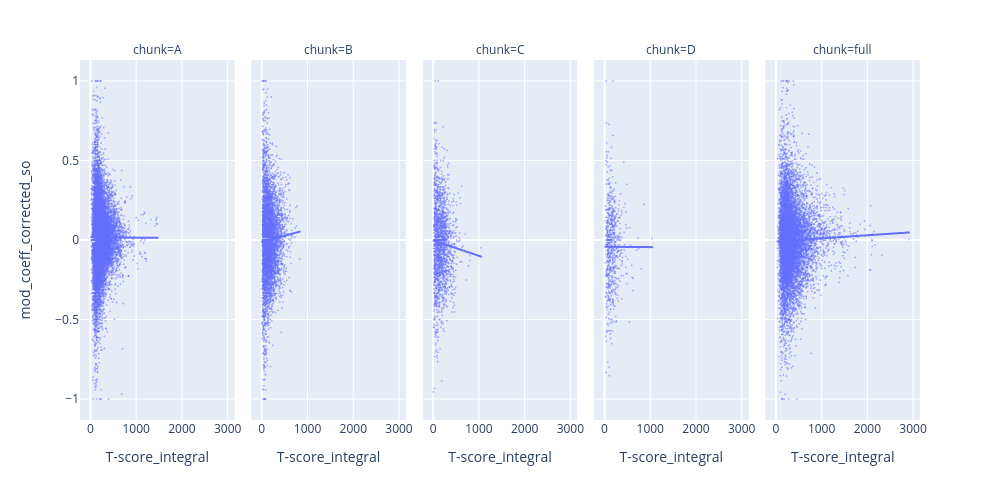

In [18]:
toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          )

fig = px.scatter(toplot, x='T-score_integral', y='mod_coeff_corrected_so', facet_col='chunk',
                 trendline='ols',
                 category_orders={'chunk':['A','B','C','D','full']})

fig.update_traces(marker=dict(size=2,opacity=0.5))

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

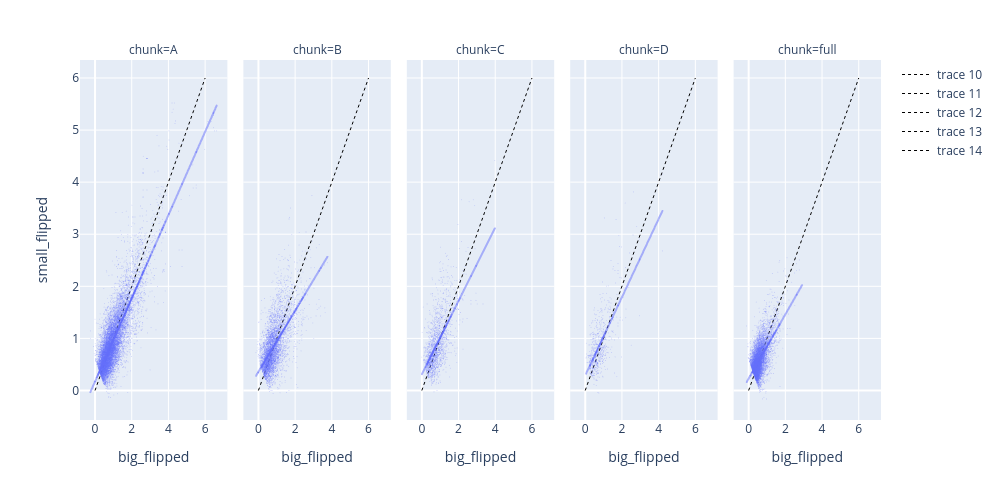

In [19]:
toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          )

fig = px.scatter(toplot, x='big_flipped', y='small_flipped', facet_col='chunk',
                 trendline='ols',
                 category_orders={'chunk':['A','B','C','D','full']})

fig.update_traces(marker=dict(size=1,
                              opacity=0.5,
                              ),
                  opacity=0.5)

for col in range(5):
    interval = [0,6] # hardcoded cause im lazy
    fig.add_trace(go.Scatter(x=interval, y=interval, mode='lines',
                             line=dict(color='black',
                                       dash='dot',
                                       width=1)),
                  col=col+1, row=1)



img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

In [20]:
for chnk in ['A', 'B', 'C', 'D', 'full']:
    toreg = toplot.query(f"chunk == '{chnk}'")
    wkx = sst.wilcoxon(toreg.big_flipped, toreg.small_flipped)
    print(f'\nchunk {chnk}: big={toreg.big_flipped.mean()}, small={toreg.small_flipped.mean()} '
          f'delta={toreg.big_flipped.mean()-toreg.small_flipped.mean()}')
    print(wkx)


chunk A: big=0.9929002753389726, small=0.9613242102558194 delta=0.03157606508315325
WilcoxonResult(statistic=35487693.5, pvalue=1.0449327040765732e-21)

chunk B: big=0.8637414088661929, small=0.8516654557514919 delta=0.012075953114700999
WilcoxonResult(statistic=5799732.5, pvalue=0.442448162487579)

chunk C: big=0.8506798604795756, small=0.8986469539934282 delta=-0.04796709351385264
WilcoxonResult(statistic=684738.0, pvalue=8.55657989368724e-06)

chunk D: big=0.815644286271787, small=0.8899669708003719 delta=-0.07432268452858493
WilcoxonResult(statistic=83516.5, pvalue=2.511721809092594e-06)

chunk full: big=0.5770517232603268, small=0.5778147371754988 delta=-0.0007630139151719728
WilcoxonResult(statistic=19879085.5, pvalue=0.4083442294422117)


n=12868 points
hacky linregress: slope0=-0.012977748305493014, slope=0.9744, intercept0=-0.004394408130441101, intercept=-0.0061, rvalue=-0.0408, pvalue=0.0000
WilcoxonResult(statistic=35487693.5, pvalue=1.0449327040765732e-21)
mean x:0.9929002753389726, mean y: 0.9613242102558194


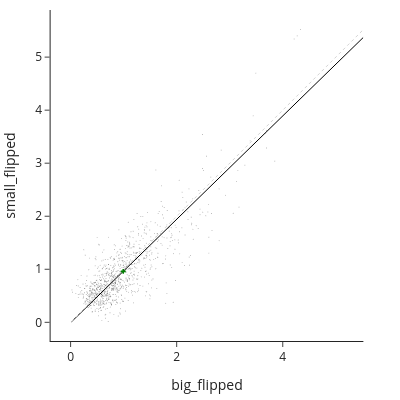

In [21]:
panelname = "second_order_scatte"

toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          f" and chunk == 'A'"
                          ).copy()


fig = plot_dev_fom_id(toplot, x='big_flipped', y='small_flipped', decimate=1000, by_quantiles=False )

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

fig.update_layout(template='simple_white',
                  margin=dict(l=10, r=10, t=10, b=10),
                  xaxis=dict(scaleanchor='y',
                             constrain='domain'))

img_bytes = fig.to_image(format="png", width=400, height=400)
Image(img_bytes)

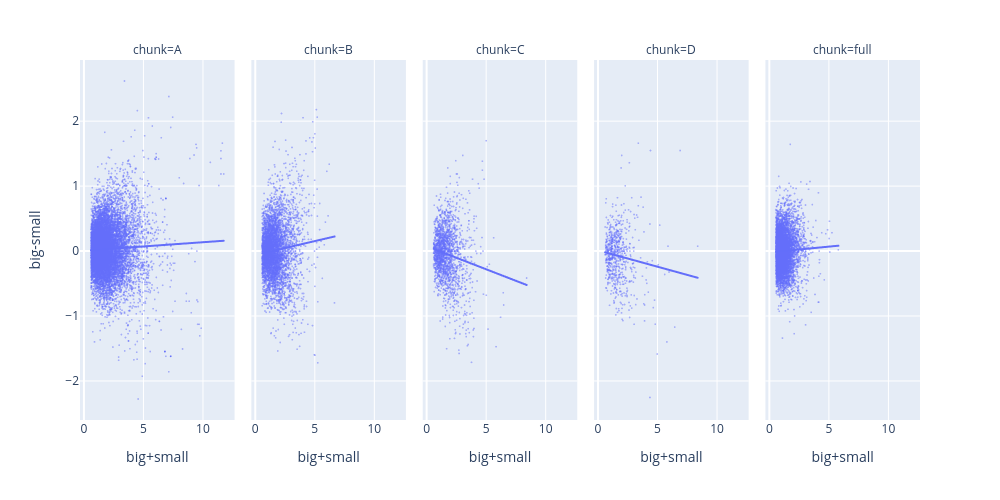

In [22]:
toplot = full_merge.query(f"small_fo > 0.1  and big_fo > 0.1"
                          f" and ((full_so <= -0.3) or (0.3 <= full_so))"
                          ).copy()

toplot['big+small'] = toplot['big_flipped'] + toplot['small_flipped']
toplot['big-small'] = toplot['big_flipped'] - toplot['small_flipped']

fig = px.scatter(toplot, x='big+small', y='big-small', facet_col='chunk',
                 trendline='ols',
                 category_orders={'chunk':['A','B','C','D','full']})
fig.update_traces(marker=dict(size=2,opacity=0.5))

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

In [23]:
for chnk in ['A','B','C','D','full']:
    toreg = toplot.query(f"chunk == '{chnk}'")
    x = toreg['big+small']
    y = toreg['big-small']
    print(f'\n{chnk}: {sst.linregress(x,y)}')


A: LinregressResult(slope=0.012977748305493069, intercept=0.006214631576672444, rvalue=0.04078843722805489, pvalue=3.684964982115389e-06, stderr=0.0028027150106945766, intercept_stderr=0.006324224597920247)

B: LinregressResult(slope=0.042619120113227715, intercept=-0.06103317809149554, rvalue=0.08888676190572183, pvalue=3.8622750614531874e-10, stderr=0.006794874766176694, intercept_stderr=0.012978621013003146)

C: LinregressResult(slope=-0.07106413974315676, intercept=0.07634731168630815, rvalue=-0.1471388717951454, pvalue=3.004975746466735e-10, stderr=0.011219444068529595, intercept_stderr=0.021772362197793875)

D: LinregressResult(slope=-0.050450589484569056, intercept=0.011726408822222298, rvalue=-0.11680478846711848, pvalue=0.002497842318878113, stderr=0.01662208388948768, intercept_stderr=0.03232305160207729)

full: LinregressResult(slope=0.017798048167131705, intercept=-0.021317382804613743, rvalue=0.03752844098474339, pvalue=0.00036279423392734017, stderr=0.0049894698302780415

### Example PSTHs

In [24]:
# first find an example, the following conditions have to be met
# possitive big first order effects (on full duration)
# possitive big second order effectse (on chunk A)
# big contextual effecs

tosort = full_merge.query("small_fo > 0.1  and big_fo > 0.1"
                          " and ((full_so <= -0.3) or (0.3 <= full_so))"
                          " and mod_coeff_corrected_fo > 0"
                          " and mod_coeff_corrected_so > 0"
                          " and chunk == 'A'").loc[:, ['id', 'context_pair', 'probe',
                                                        'mod_coeff_corrected_fo', 'mod_coeff_corrected_so',
                                                        'T-score_integral']].copy()
tosort['ctx_mod_norm'] = tosort['T-score_integral'] / tosort['T-score_integral'].max()
tosort['euc_dist'] = np.linalg.norm(tosort.loc[:,
                                    ['mod_coeff_corrected_fo',
                                     'mod_coeff_corrected_so',
                                     'ctx_mod_norm']].values,
                                    axis=1)

tosort.sort_values(by='euc_dist', ascending=False, inplace=True, ignore_index=True)

tosort

,id,context_pair,probe,mod_coeff_corrected_fo,mod_coeff_corrected_so,T-score_integral,ctx_mod_norm,euc_dist
0,ARM031a-52-6,03_04,2,0.651578,1.000000,159.083267,0.134336,1.201083
1,TNC019a-031-2,00_08,9,0.506281,1.000000,164.085129,0.138560,1.129389
2,ARM031a-38-3,01_03,3,0.568314,0.935484,72.291389,0.061046,1.096284
3,ARM021b-06-3,00_02,3,0.364405,0.167630,1184.220703,1.000000,1.077446
4,ARM021b-06-3,00_04,3,0.364405,0.174419,1177.375488,0.994220,1.073166
...,...,...,...,...,...,...,...,...
4886,TNC023a-020-1,08_09,1,0.005432,0.052632,64.886856,0.054793,0.076170
4887,TNC045a-045-4,03_10,7,0.005130,0.023256,76.991722,0.065015,0.069239
4888,TNC047a-52-1,00_09,4,0.002057,0.028571,41.637482,0.035160,0.045352
4889,TNC014a-22-2,01_05,8,0.009915,0.028571,30.637867,0.025872,0.039799


[nems_lbhb.baphy_io INFO] Setting chancount=0 for stimfmt=envelope
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/316/ARM031a_eadb133cc5a37daf55238a66726cbe8335080f96.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM031/ARM031a10_p_CPN.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Armillaria/ARM031/ARM031a11_p_CPN.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Armillaria/ARM031/ARM031a11_p_CPN.evp


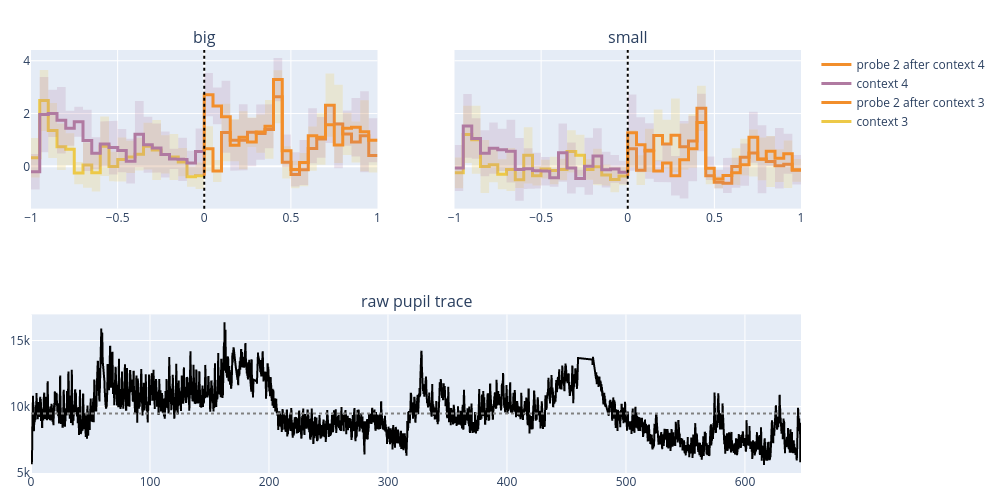

In [25]:
ii = 0
cellid = tosort.loc[ii,'id']
contexts = [int(cc) for cc in tosort.loc[ii,'context_pair'].split('_')]
probe = tosort.loc[ii,'probe']

fig = plot_pupil_effect(cellid, contexts, probe)

img_bytes = fig.to_image(format="png", width=1000, height=500)
Image(img_bytes)

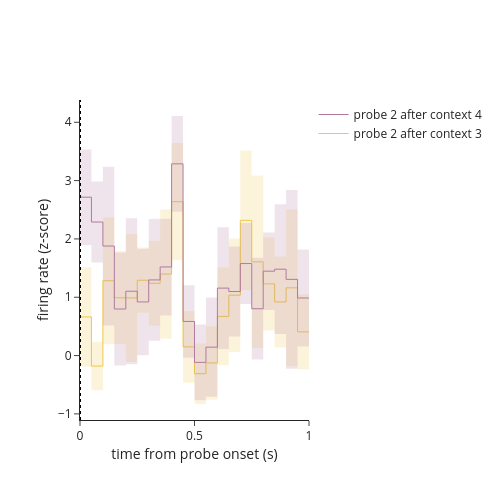

In [26]:
panelname = 'big_psth'
fig = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR,
                    pupil='big', simplify=True, part='probe')

fig.update_traces(line=dict(width=1))


if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

img_bytes = fig.to_image(format="png", width=500, height=500)
Image(img_bytes)

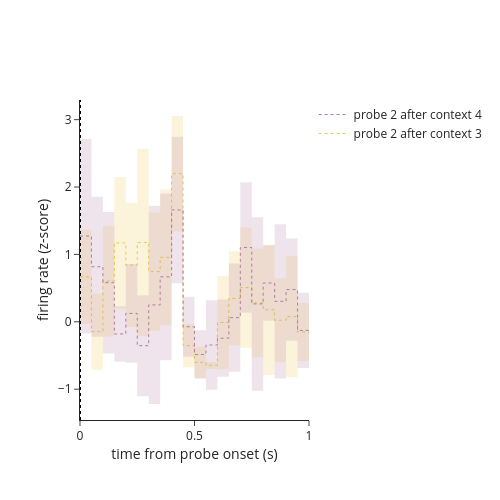

In [27]:
panelname = 'small_psth'
fig = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR,
                    pupil='small', simplify=True, part='probe')

fig.update_traces(line=dict(dash='dot', width=1))

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

img_bytes = fig.to_image(format="png", width=500, height=500)
Image(img_bytes)

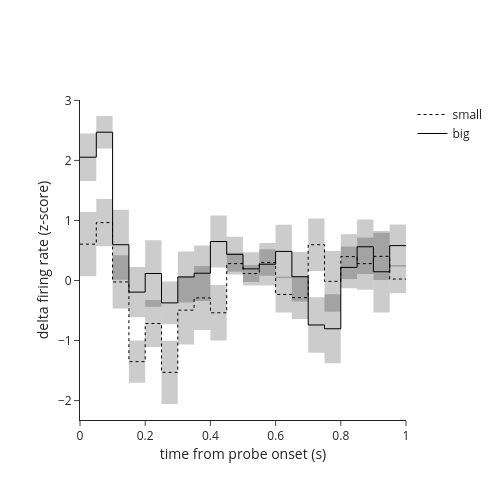

In [28]:
panelname = 'secon_ord_psth'
fig = plot_pupil_so_effects(cellid, contexts, probe, raster_fs=20)

fig.update_traces(line=dict(width=1))

if panelname in panels.keys():
    panels.pop(panelname)

panels[panelname].extend(fig['data'])

img_bytes = fig.to_image(format="png", width=500, height=500)
Image(img_bytes)

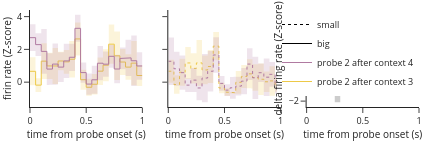

In [29]:
fig = make_subplots(1, 3, shared_xaxes='all')

# big pupil
f = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR,
                  pupil='big', simplify=True, part='probe')
f.update_traces(line=dict(width=1))
f = f['data']
fig.add_traces(f, cols=[1] * len(f), rows=[1] * len(f))

# small pupil
f = plot_raw_pair(cellid, contexts, probe, raster_fs=20, colors=TENCOLOR,
                  pupil='small', simplify=True, part='probe')
f.update_traces(line=dict(dash='dot', width=1), showlegend=False)
f = f['data']
fig.add_traces(f, cols=[2] * len(f), rows=[1] * len(f))

# delta firing rates
f = plot_pupil_so_effects(cellid, contexts, probe, raster_fs=20)
f.update_traces(line=dict(width=1))

f = f['data']
fig.add_traces(f, cols=[3] * len(f), rows=[1] * len(f))

w, h = 4.5, 1.5
fig.update_layout(template='simple_white',
                  width=96 * w, height=96 * h,
                  margin=dict(l=10, r=10, t=10, b=10),

                  yaxis_title_text='firin rate (Z-score)',
                  yaxis2=dict(matches='y', showticklabels=False),
                  yaxis3=dict(title_text='delta firing rate (Z-score)'),
                  legend=dict(xanchor='right', x=1,
                              yanchor='top', y=1,
                              font_size=9,
                              title=dict(text='')),
                  )

fig.update_xaxes(title=dict(text='time from probe onset (s)', font_size=10, standoff=0),
                 tickfont_size=9)
fig.update_yaxes(title=dict(font_size=10, standoff=0),
                 tickfont_size=9,
                 autorange=True)

filename = folder / 'fig6_psth_examples'

fig.write_image(filename.with_suffix('.png'), scale=4)
fig.write_image(filename.with_suffix('.svg'))

img_bytes = fig.to_image(format="png", width=96 * w, height=96 * h, scale=1)
Image(img_bytes)

# full figure
deprecated

In [30]:
def define_subplots():
    fig = make_subplots(rows=2, cols=3, vertical_spacing=0.1, horizontal_spacing=0.05,
                        column_width=[1 / 3, 1 / 3, 1 / 3],
                        row_heights=[1 / 2, 1 / 2],
                        subplot_titles=['first order effects', 'second order effects', 'modulation index',
                                        'big pupil eg', 'small pupil eg', 'contextual effects'],
                        specs=[[{}, {}, {}],
                               [{}, {}, {}]])
    # figure size in inches at different PPIs
    ppi = 96  # www standard

    heigh = 4
    width = 6  # in inches
    _ = fig.update_layout(template='simple_white',
                          margin=dict(l=10, r=10, t=20, b=10),
                          width=round(ppi * width), height=round(ppi * heigh),

                          # first order scatter
                          xaxis=dict(autorange=True,
                                     title_text='big pupil fr',
                                     constrain='domain',
                                     ),
                          yaxis=dict(scaleanchor='x',
                                     title_text='small pupil fr',
                                     constrain='domain',
                                     ),

                          # second order scatter
                          xaxis2=dict(autorange=True,
                                      title_text='big pupil delta-fr',
                                      constrain='domain',
                                      ),
                          yaxis2=dict(scaleanchor='x2',
                                      title_text='small pupil delta-fr',
                                      constrain='domain',
                                      ),

                          # first vs second ord MI
                          xaxis3=dict(range=[-1, 1],
                                      title_text='first order MI',
                                      constrain='domain'
                                      ),
                          yaxis3=dict(range=[-1, 1],
                                      title_text='second order MI',
                                      scaleanchor='x3',
                                      constrain='domain'
                                      ),

                          # PSTH big pupil
                          xaxis4=dict(constrain='domain',
                                      title_text='time from probe onset (s)'
                                      ),
                          yaxis4=dict(autorange=True,
                                      title_text='firing rate (z-score)'),

                          # PSTH small pupil
                          xaxis5=dict(constrain='domain',
                                      title_text='time from probe onset (s)'),
                          yaxis5=dict(matches='y4',
                                      showticklabels=False),

                          # delta PSTHs
                          xaxis6=dict(title_text='time from probe onset (s)'),
                          yaxis6=dict(scaleanchor='y4',
                                      autorange=True,
                                      title_text='delta firing rate (z-score)'),
                          showlegend=False,
                          font_size=10,
                          )
    fig.update_xaxes(title=dict(standoff=0), tickfont_size=9)
    fig.update_yaxes(title=dict(standoff=0), tickfont_size=9)

    # add letter annotations for subplots
    anotations = [
        ('a', 0, 1),
        ('b', 1 / 3, 1),
        ('c', 2 / 3, 1),
        ('d', 0, 1 / 2),
        ('e', 1 / 3, 1 / 2),
        ('f', 2 / 3, 1 / 2),
    ]

    for letter, x, y in anotations:
        fig.add_annotation(x=x, y=y,
                           text=f'<b>{letter}</b>', font_size=12,
                           xref='paper', yref='paper',
                           xanchor='center', yanchor='middle',
                           showarrow=False)

    return fig, round(ppi * width), round(ppi * heigh)


f, pw, ph = define_subplots()
f.print_grid()
# img_bytes = f.to_image(format="png", width=pw, height=ph)
# Image(img_bytes)

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



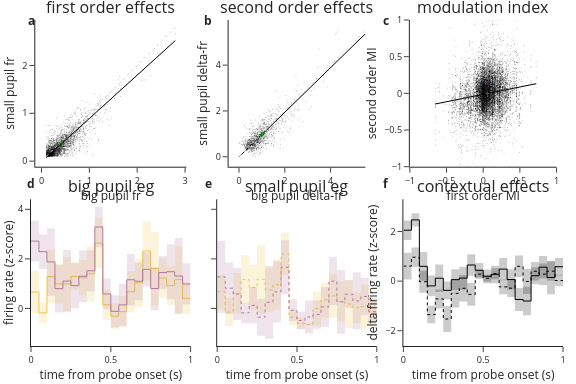

In [31]:
fig, pw, ph = define_subplots()

# top left
pan = panels['first_order_scatter']
fig.add_traces(pan, cols=[1] * len(pan), rows=[1] * len(pan))

# top center
pan = panels['second_order_scatte']
fig.add_traces(pan, cols=[2] * len(pan), rows=[1] * len(pan))

# top right
pan = panels['first_vs_second_order']
fig.add_traces(pan, cols=[3] * len(pan), rows=[1] * len(pan))

# bottom left
pan = panels['big_psth']
fig.add_traces(pan, cols=[1] * len(pan), rows=[2] * len(pan))

# bottom center
pan = panels['small_psth']
fig.add_traces(pan, cols=[2] * len(pan), rows=[2] * len(pan))

# bottom right
pan = panels['secon_ord_psth']
fig.add_traces(pan, cols=[3] * len(pan), rows=[2] * len(pan))

img_bytes = fig.to_image(format="png", width=pw, height=ph)
Image(img_bytes)